In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

# Posterior Predictive Distributions for Stochastic Predictions  

Suppose one is interested in parameter estimation for a theoretical model $y_\text{th}$ that depends on a set of parameters $\vec{a}$.
Upon finding the posterior $pr(\vec{a} \,|\, y_\text{exp})$, it can be useful to look at the distribution of $y_\text{th}(\vec{a})$ across the posterior distribution of $\vec{a}$.
This is given by the posterior predictive distribution (PPD)
$$
    \text{pr}(y_\text{th} \,|\, y_\text{exp}) = \int d\vec{a} \,\text{pr}(y_\text{th} \,|\, \vec{a}, y_\text{exp}) \,\text{pr}(\vec{a} \,|\, y_\text{exp})
$$

If the theory is determined exactly from the parameters $\vec{a}$, then one is able to write $\text{pr}(y_\text{th} \,|\, \vec{a}, y_\text{exp}) = \text{pr}(y_\text{th} \,|\, \vec{a})$, **but this is not always the case**.
One example of a PPD that cannot be simplified in this way is the PPD for the theoretical discrepancy:
$$
    \text{pr}(y_\text{th} + \delta y_\text{th} \,|\, y_\text{exp})
$$
where
$$
    y_\text{exp} = y_\text{th} + \delta y_\text{th} + \delta y_\text{exp}.
$$
The discrepancy $\delta y_\text{th}$ is generally unknown, and so it is given a distribution.
A common prior is to state that the discrepancy follows a Gaussian process (GP) with some kernel $\kappa$
$$
    \delta y_\text{th}(x) \sim GP[0, \kappa(x, x')],
$$
where it is assumed that $\delta y_\text{th}$ is independent of the parameters $\vec{a}$.
Because $\delta y_\text{th}$ is **not** uniquely determined by $\vec{a}$, then the experimental data does have an impact on $\text{pr}(y_\text{th} + \delta y_\text{th} \,|\, \vec{a}, y_\text{exp})$, which is in fact the *conditional* probability density for the Gaussian process.

We can illustrate this using an example, inspired by the model proposed in [this](#MelendezGP) reference.
For the theory (and the discrepancy), we will consider a simple geometric series whose coefficients are to be determined.
These coefficients will play the role of $\vec{a}$.
The series, which constitute $y_\text{th}$ will be terminated at some order $k$, and the subsequent terms will be placed in $\delta y_\text{th}$, aka, the truncation error.
Note that, although the coefficients in the geometric series are treated as constants, this case generalizes nicely to when the coefficients are themselves Gaussian processes.

## Parameters & Data Generation

In [2]:
k_max = 7  # The total max order (including truncation error)
k = 3  # The max order in y_th
cbar = 1  # The standard deviation of the parameters
sd_exp = 0.2  # The experimental standard deviation
N = 50  # Number of data to use in training

y_ref = np.ones(N)  # A constant scalar that multiplies the series
x = np.linspace(0.01, 0.9, N)  # The ratio x^n in the geometric series
higher_orders = np.arange(k+1, k_max)  # These are in the truncation error
orders = np.arange(k)  # These are in y_th

# Make everything repeatable
rng = np.random.default_rng(5)  #3

# The coefficients of the geometric series
c_true_all = rng.normal(0, cbar, k_max)
c_true_higher = c_true_all[k+1:]
c_true = c_true_all[:k]

# Set up toy predictions and experiment
X = np.array([y_ref * x ** n for n in orders]).T
y_th = y_ref * np.sum(c_true * x[:, None] ** orders, axis=-1)
dy_th = y_ref * np.sum(c_true_higher * x[:, None] ** higher_orders, axis=-1)
dy_exp = rng.normal(0, sd_exp, N)
y_exp = y_th + dy_th + dy_exp

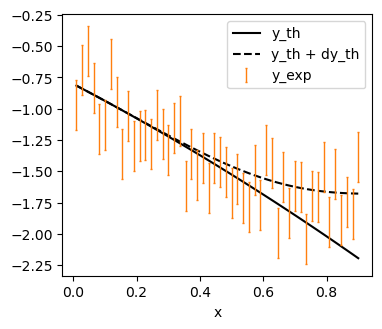

In [3]:
fig, ax = plt.subplots(figsize=(4, 3.4))

plt.plot(x, y_th, label="y_th", c="k")
plt.plot(x, y_th + dy_th, label="y_th + dy_th", c="k", ls='--')
plt.errorbar(x, y_exp, sd_exp, lw=0, elinewidth=1, barsabove=True, capsize=1, label="y_exp", c="C1")
plt.legend()
ax.set_xlabel("x");

## Fit Coefficients

This is a linear model and so we can use the standard linear regression equations to find the posterior distribution
$$
    \vec{a} \,|\, y_{\text{exp}} \sim N[\mu_a, \Sigma_a] \\
    \mu_a = \Sigma_a X^T (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} y_\text{exp} \\
    \Sigma_a = [X^T (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} X]^{-1}
$$

In [4]:
Sigma_th = y_ref[:, None] * y_ref * cbar ** 2 * np.sum([x[:, None]**n * x**n for n in higher_orders], axis=0)
Sigma_exp = sd_exp ** 2 * np.eye(N)

In [5]:
c_var_inv = X.T @ np.linalg.solve(Sigma_th + Sigma_exp, X)
c_var = np.linalg.inv(c_var_inv)
c_est = np.linalg.solve(c_var_inv, X.T @ np.linalg.solve(Sigma_th + Sigma_exp, y_exp))

## PPD Calculation

The PPD for the theory prediction can be calculated analytically. If $y_\text{th} = X \vec{a}$, then
$$
  y_\text{th} \,|\, y_\text{exp} \sim N[X\mu_a, X \Sigma_a X^T]
$$

In [6]:
y_th_ppd_mean = y_ref * np.sum(c_est * x[:, None] ** orders, axis=-1)
y_th_ppd_stdv = np.sqrt(np.diag(X @ c_var @ X.T))

The PPD when including truncation error is slightly trickier, but still analytic.
Here we must compute
$$
    \text{pr}(y_\text{th} + \delta y_\text{th} \,|\, \vec{a}, y_\text{exp}),
$$
which is the conditional distribution for the GP.
Thus, we compute conditional GP equations *first*, and then sum over all $\vec{a}$.
The conditional GP equations are well known.
They can be found, e.g., [here](#MelendezGP) in Eqs. (10)-(15). Once the conditional GP is given as a function of $\vec{a}$,
$$
    y_\text{th} + \delta y_\text{th} \,|\, \vec{a}, y_\text{exp} \sim N[Z\vec{a} + \Sigma_\text{th} (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} y_\text{exp}, \Sigma_\text{th} + \Sigma_\text{th} (\Sigma_\text{th} + \Sigma_\text{exp})^{-1}\Sigma_\text{th}] \\
    Z = X - \Sigma_\text{th} (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} X
$$
then they can be integrated out as done above. In this case, this yields
$$
y_\text{th} + \delta y_\text{th} \,|\, y_\text{exp} \sim N[Z\mu_a + \Sigma_\text{th} (\Sigma_\text{th} + \Sigma_\text{exp})^{-1} y_\text{exp}, \Sigma_\text{th} + \Sigma_\text{th} (\Sigma_\text{th} + \Sigma_\text{exp})^{-1}\Sigma_\text{th} + Z\Sigma_a Z^T]
$$

In [7]:
y_tot_ppd_mean = y_th_ppd_mean + Sigma_th @ np.linalg.solve(Sigma_th + Sigma_exp, y_exp - y_th_ppd_mean)

Z = X - Sigma_th @ np.linalg.solve(Sigma_th + Sigma_exp, X)

y_tot_ppd_cov = Sigma_th - Sigma_th @ np.linalg.solve(Sigma_th + Sigma_exp, Sigma_th) + Z @ c_var @ Z.T
y_tot_ppd_stdv = np.sqrt(np.diag(y_tot_ppd_cov))

## Results

First, the simple PPD using the theory $y_\text{th}$ only.

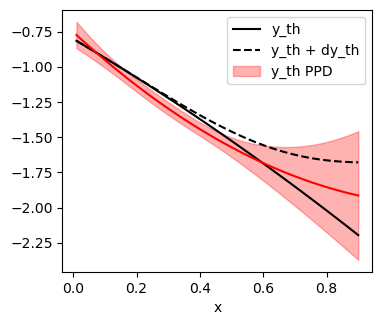

In [8]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c='k', ls='--')
ax.plot(x, y_th_ppd_mean, c="r")
ax.fill_between(x, y_th_ppd_mean+y_th_ppd_stdv, y_th_ppd_mean - y_th_ppd_stdv, label="y_th PPD", color="r", alpha=0.3)
ax.legend()
ax.set_xlabel("x");

The PPD for $y_\text{th} + \delta y_\text{th}$ is, surprisingly, even tighter than the first! It is also spot on top of the true value. In this case, $\delta y_\text{th}$ is doing **exactly what it was supposed to do**, which is soak up the deviation between theory and experiment.

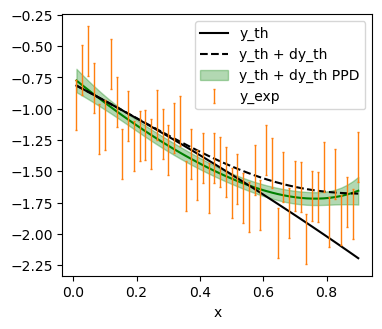

In [9]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c="k", ls='--')
plt.errorbar(x, y_exp, sd_exp, lw=0, elinewidth=1, barsabove=True, capsize=1, label="y_exp", c="C1")
ax.plot(x, y_tot_ppd_mean, c="g", zorder=0)
ax.fill_between(x, y_tot_ppd_mean+y_tot_ppd_stdv, y_tot_ppd_mean - y_tot_ppd_stdv, label="y_th + dy_th PPD", color="g", alpha=0.3, zorder=0)
ax.legend()
ax.set_xlabel("x");

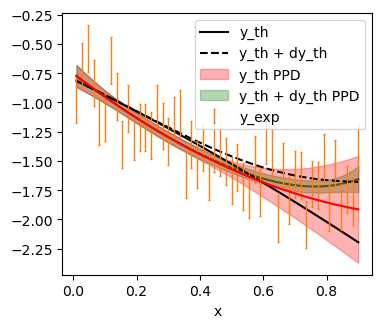

In [10]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c="k", ls='--')
plt.errorbar(x, y_exp, sd_exp, lw=0, elinewidth=1, barsabove=True, capsize=1, label="y_exp", c="C1")
ax.plot(x, y_th_ppd_mean, c="r")
ax.fill_between(x, y_th_ppd_mean+y_th_ppd_stdv, y_th_ppd_mean - y_th_ppd_stdv, label="y_th PPD", color="r", alpha=0.3)
ax.plot(x, y_tot_ppd_mean, c="g", zorder=0)
ax.fill_between(x, y_tot_ppd_mean+y_tot_ppd_stdv, y_tot_ppd_mean - y_tot_ppd_stdv, label="y_th + dy_th PPD", color="g", alpha=0.3, zorder=0)
ax.legend()
ax.set_xlabel("x");

## Non-PPD Calculation


Although not the PPD, it is sometimes useful to look at the distribution of $y_\text{th} + \delta y_\text{th}$ sampled over our posterior values for $\vec{a}$. So rather than conditioning $y_\text{th} + \delta y_\text{th}$ on the experimental values, we instead use its unconditional distribution. This quantity can be described as
$$
    y_\text{th} + \delta y_\text{th} \, | \, I_{\vec{a} \,|\, y_\text{exp}}
$$
where $I_{\vec{a} \,|\, y_\text{exp}}$ is the information about the posterior distribution of $\vec{a}$.

In [11]:
y_th_non_ppd_stdv = np.sqrt(np.diag(Sigma_th)) + np.sqrt(np.diag(X @ c_var @ X.T))

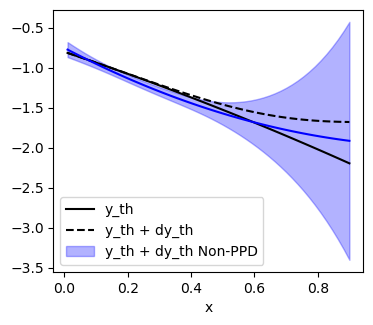

In [12]:
fig, ax = plt.subplots(figsize=(4, 3.4))

ax.plot(x, y_th, label="y_th", c="k")
ax.plot(x, y_th + dy_th, label="y_th + dy_th", c='k', ls='--')
ax.plot(x, y_th_ppd_mean, c="b")
ax.fill_between(x, y_th_ppd_mean + y_th_non_ppd_stdv, y_th_ppd_mean - y_th_non_ppd_stdv, label="y_th + dy_th Non-PPD", color="b", alpha=0.3)
ax.legend()
ax.set_xlabel("x");

## References

* <a id="MelendezGP" /> Melendez, J. A., Furnstahl, R. J., Phillips, D. R., Pratola, M. T. & Wesolowski, S. Quantifying correlated truncation errors in effective field theory. Phys Rev C 100, 044001 (2019).